In [1]:
# %%
from functools import partial
import jax.numpy as jnp
import jax.random as random
from flax import optim
from modax.training import create_update, train_max_iter
from nf import AmortizedNormalizingFlow
from data import random_walk
import matplotlib.pyplot as plt
import seaborn as sns
import jax
sns.set()

%load_ext autoreload
%autoreload 2

In [2]:
key = random.PRNGKey(42)
# %% Making sample dataset
def dataset():
    n_steps = 50
    n_walkers = 100
    D = 1.5
    v = 0.1
    dt = 0.05

    def initial_condition(loc, width, key, shape):
        return loc + width * random.normal(key, shape)
    ini = partial(initial_condition, -1, 0.5)
    locs, t = random_walk(key, ini, n_steps, n_walkers, D, v, dt=dt)
    
    return jnp.expand_dims(locs, -1), jnp.expand_dims(t, -1)


X, t = dataset()

In [3]:
def loss_fn(params, state, model, x):
    log_pz, log_det = model.apply(params, x)
    log_p = log_pz + log_det
    loss = -jnp.sum(log_pz + log_det)
    
    metrics = {"loss": loss}
    return loss, (state, metrics, (log_p, log_pz, log_det))

In [14]:
model = AmortizedNormalizingFlow([100], 10)
params = model.init(key, (X, t))

In [15]:
model.apply(params, (X, t))[0].shape

(51, 100, 1)

In [16]:
# %% Initializing model
optimizer_def = optim.Adam(learning_rate=2e-3, beta1=0.99, beta2=0.99)
optimizer = optimizer_def.create(params)

# Compiling train step
update = create_update(loss_fn, (model, (X, t)))

In [17]:
optimizer, _ = train_max_iter(update, optimizer, None, 10000)

Loss step 0: 194300.875
Loss step 500: 9406.42578125
Loss step 1000: 8926.6982421875
Loss step 1500: 8709.55078125
Loss step 2000: 8679.548828125
Loss step 2500: 8661.9921875
Loss step 3000: 8648.873046875
Loss step 3500: 8641.654296875
Loss step 4000: 8635.021484375
Loss step 4500: 8631.47265625
Loss step 5000: 8629.919921875
Loss step 5500: 8629.224609375
Loss step 6000: 8629.26171875
Loss step 6500: 8627.1943359375
Loss step 7000: 8625.71484375
Loss step 7500: 8624.73828125
Loss step 8000: 8624.39453125
Loss step 8500: 8621.849609375
Loss step 9000: 8634.5859375
Loss step 9500: 8620.0302734375


In [18]:
x = jnp.linspace(-5, 5, 100)
x_grid = jnp.meshgrid(x, t.squeeze())[0][:, :, None]

In [19]:
# lets look at the output
log_pz, log_det = model.apply(optimizer.target, (x_grid, t))
inferred_p = jnp.exp(log_pz + log_det).squeeze()

In [20]:
inferred_p.shape

(51, 100)

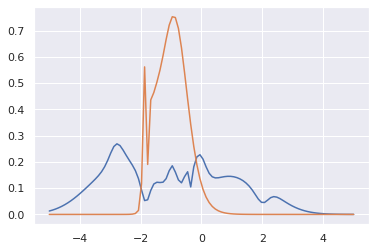

In [21]:
plt.plot(x, inferred_p[-1])
plt.plot(x, inferred_p[0])

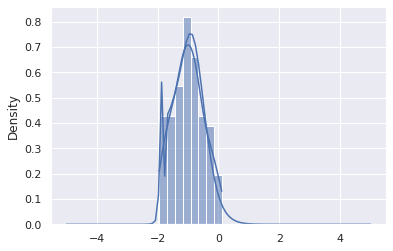

In [22]:
sns.histplot(X[0].squeeze(), kde=True, stat='density')
plt.plot(x, inferred_p[0])
#plt.plot(x, inferred_p[-1])

Text(0.5, 0.98, 'Advection-diffusion')

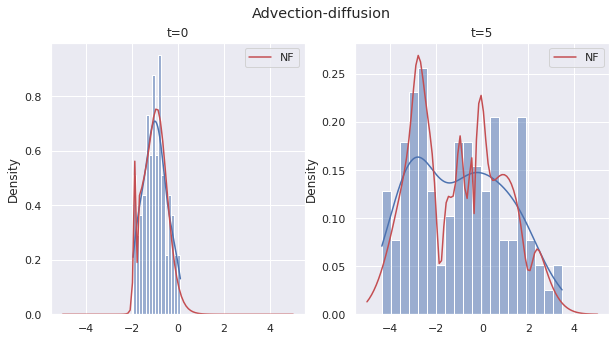

In [24]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.title('t=0')
sns.histplot(X[0].squeeze(), kde=True, stat='density', bins=15)
plt.plot(x, inferred_p[0], color='r', label='NF')
plt.legend()

plt.subplot(122)
plt.title('t=5')
sns.histplot(X[-1].squeeze(), kde=True, stat='density', bins=20)
plt.plot(x, inferred_p[-1], color='r', label='NF')
plt.legend()

plt.suptitle("Advection-diffusion")

<AxesSubplot:>

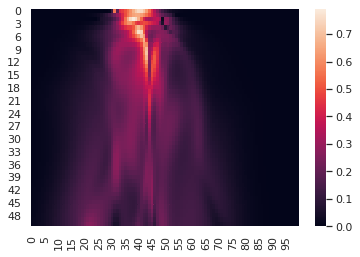

In [25]:
sns.heatmap(inferred_p)